In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import IPython
# necessite scikit-image 
from skimage import io as skio


# POUR LA MORPHO
from skimage.segmentation import watershed 
from skimage.feature import peak_local_max



In [2]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES: 
colaboratory=False #mettre True si vous utilisez google colab
notebook=False   # mettre Trus si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    





In [3]:
#%% fonction pour voir une image
def viewimage(im, normalize=True,titre='',displayfilename=False):
    imin=im.copy().astype(np.float32)
    if normalize:
        imin-=imin.min()
    if imin.max()>0:
        imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255


    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

#si on est dans un notebook (y compris dans colab), on utilise bokeh pour visualiser

usebokeh= colaboratory or notebook
if usebokeh:
    def normalise_image_pour_bokeh(X,normalise,MINI,MAXI):
        imt=np.copy(X.copy())
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
        imt*=255
      
        sortie=np.empty((*imt.shape,4),dtype=np.uint8)
        for k in range(3):
            sortie[:,:,k]=imt
        sortie[:,:,3]=255
        return sortie
    def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
        
        img=normalise_image_pour_bokeh(np.flipud(im),normalise,MINI,MAXI)# np.flipud(np.fliplr(im)))
        p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
        p.x_range.range_padding = p.y_range.range_padding = 0

        # must give a vector of images
        p.image_rgba(image=[img], x=0,y=0, dw=im.shape[1], dh=im.shape[0])
        showbokeh(p)

  


In [4]:
def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out    

def degrade_image(im,br): 
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py): 
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape 
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))
    
    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]
    
    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser 
# la fonctionnelle E2 par descente de gradient nous avons choisi 
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive
     

def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """
     
    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
    denom=np.vectorize(np.complex)(np.zeros((sy,sx)))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I): 
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax): 
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman 
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))
    
    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P                

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2 
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))

In [5]:
#%% lire une image

im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())



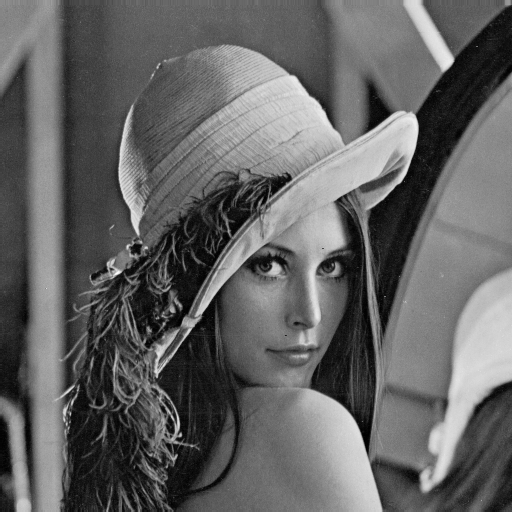

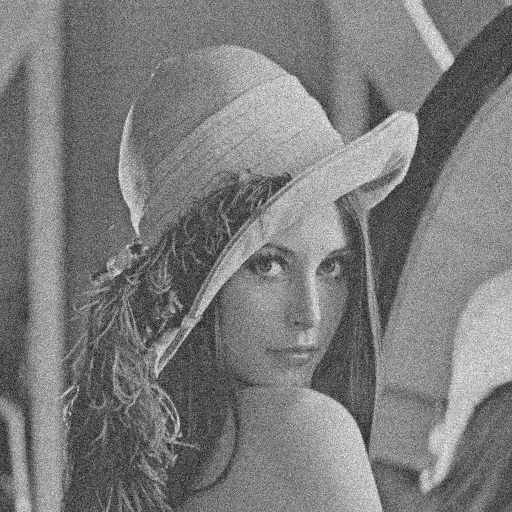

In [7]:
#%%

# voir l'image
viewimage(im,titre='ORIGINALE')
#degrader une image

imb=degrade_image(im,25)

# voir l'image bruitée 
viewimage(imb,titre='BRUITEE')



C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:92: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:93: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zero

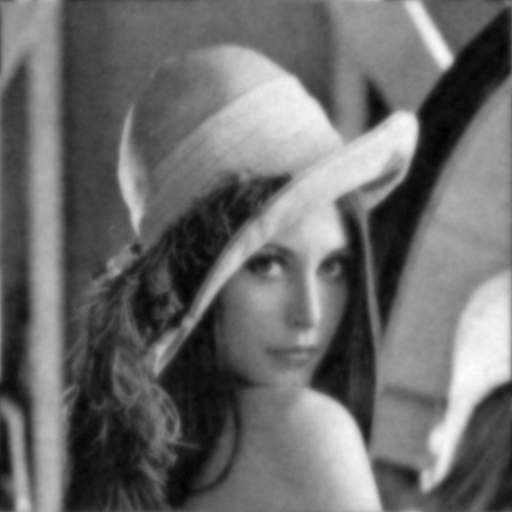

In [11]:
#%% restauration quadratique : exemple
lamb=10
restau=minimisation_quadratique(imb,lamb)
viewimage(restau,titre='RESTQUAD_LAMB='+str(lamb))



In [15]:
def find_optimal_lambda(noisy_image, tolerance=1e-5, max_iter=100, sigma = 5):
    lower_lambda, upper_lambda = 0.01, 10
    target_norm = im.size * sigma

    for i in range(max_iter):
        lambda_test = (lower_lambda + upper_lambda) / 2
        denoised_image = minimisation_quadratique(noisy_image, lambda_test)
        current_norm = norm2(denoised_image - noisy_image)**2

        if np.abs(current_norm - target_norm) < tolerance:
            return lambda_test

        if (current_norm - target_norm) > 0:
            upper_lambda = lambda_test
        else:
            lower_lambda = lambda_test

    return (lower_lambda + upper_lambda) / 2

im5 = degrade_image(im, 5)

optimal_lambda = find_optimal_lambda(im5)

print("Optimal Lambda:", optimal_lambda)

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:92: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:93: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zero

Optimal Lambda: 0.09241470884246665


C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:92: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:93: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zero

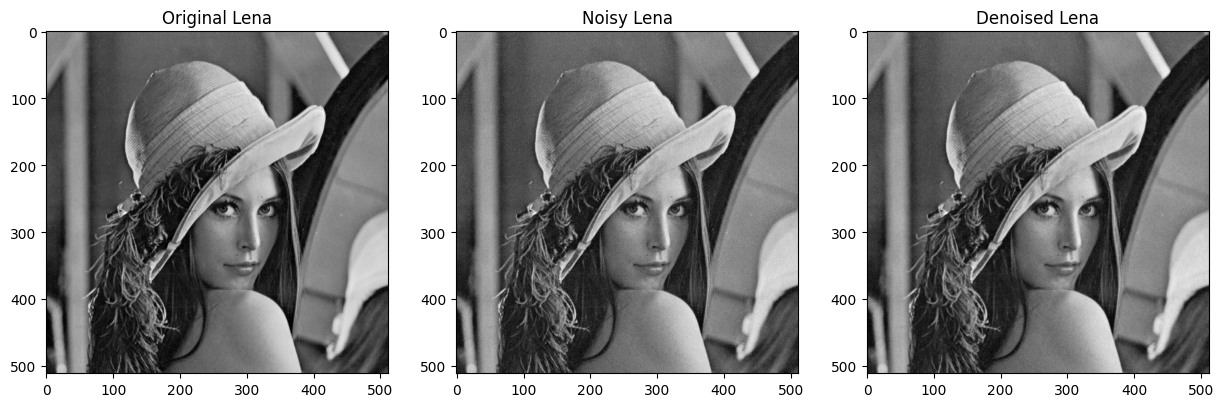

In [16]:
denoised_lena = minimisation_quadratique(im5, optimal_lambda)

# Display images
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(im, cmap='gray'), plt.title('Original Lena')
plt.subplot(132), plt.imshow(im5, cmap='gray'), plt.title('Noisy Lena')
plt.subplot(133), plt.imshow(denoised_lena, cmap='gray'), plt.title('Denoised Lena')
plt.show()

In [19]:
####Find the optimal lambda for the image imb####
def optimal_lambda_u_parfait(u, v, lambda_values):
    best_lambda = None
    min_error = float('inf')
    errors = []  # store the errors
    
    for lambda_test in lambda_values:
        tilde_u = minimisation_quadratique(v, lambda_test)
        error = norm2(u - tilde_u)**2
        errors.append(error) 
        
        if error < min_error:
            min_error = error
            best_lambda = lambda_test
            
    return best_lambda, min_error, errors  

# Define a range of lambda values to test
lambda_values = np.logspace(-3, 3, 100) 

optimal_lambda, min_error, errors = optimal_lambda_u_parfait(im, imb, lambda_values)

print(f"Optimal Lambda: {optimal_lambda}")
print(f"Minimum Squared Error: {min_error}")

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:92: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:93: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zero

Optimal Lambda: 1.232846739442066
Minimum Squared Error: 28148955.062672965


C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:92: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:93: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zero

0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.17500000000000002
0.18
0.185
0.19
0.195
0.2
0.20500000000000002
0.21
0.215
0.22
0.225
0.23
0.23500000000000001
0.24
0.245


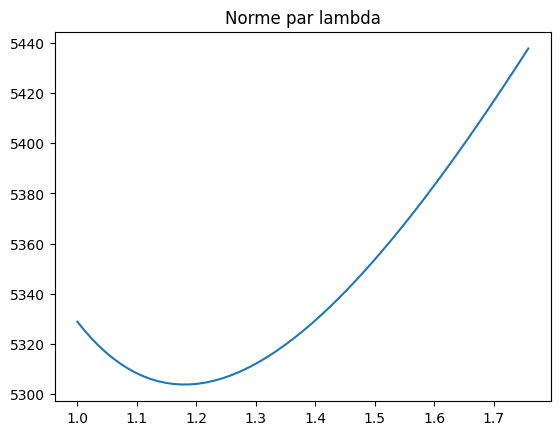

In [25]:
#%% COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs 
# parametres de regularisation 

errq=[]
errvt=[]
erreur=[]
vk=np.arange(0,0.25,0.005)
for k in vk: 
    print (k)
    restq=minimisation_quadratique(imb,10**(k))
    #errq.append[]=norm2(restq-myim);
    #restva=vartotale_Chambolle(imb,10**(k));
    #restq=minimisation_quadratique(imb,10**(k))
    erreur.append(norm2(im-restq))
    #errvt.append(norm2(restva-myim));
    


plt.plot(10**vk,erreur)
plt.title("Norme par lambda")
plt.show()



In [26]:
#%%
u1,en1=minimise_TV_gradient(imb, 40, 1, 20)
u05,en05=minimise_TV_gradient(imb, 40, 0.5, 20)
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 20)
#u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


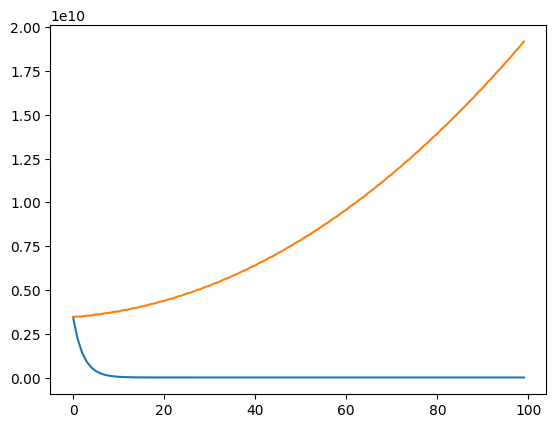

In [27]:
#%%
myim=imread('lena.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u,energ2)=minimise_TV_gradient(imb,1,1,100)       # pas = 1
plt.plot(energ)
plt.plot(energ2)


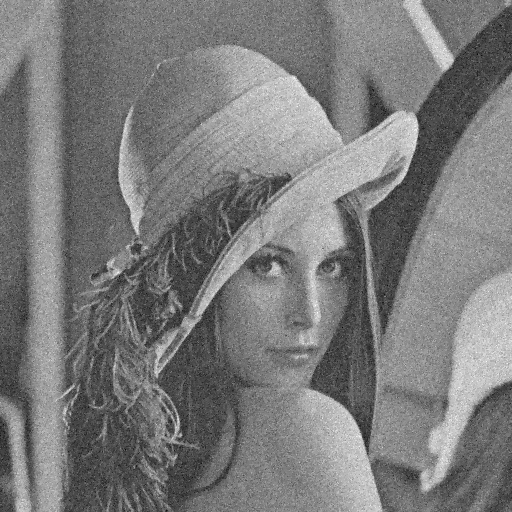

In [28]:
restau = vartotale_Chambolle(imb, lamb)
viewimage(restau,titre='RESTVARTOTALE')


In [30]:
####Comparison of methods for different lambdas####

errq = []
errvt = []
vk = np.logspace(-3, 3, 30)
for k in vk:
    restq = minimisation_quadratique(imb, k)
    errq.append(norm2(restq - im))
    
    restva = vartotale_Chambolle(imb, k)
    errvt.append(norm2(restva - im))

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:92: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:93: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zero

In [31]:
min_errq_index = np.argmin(errq)
min_errq = errq[min_errq_index]
corresponding_vk_q = vk[min_errq_index]

min_errvt_index = np.argmin(errvt)
min_errvt = errvt[min_errvt_index]
corresponding_vk_vt = vk[min_errvt_index]

print(f"Optimal Lambda Quadratique: {corresponding_vk_q}")
print(f"Optimal Lambda TV: {corresponding_vk_vt}")

Optimal Lambda Quadratique: 1.2689610031679222
Optimal Lambda TV: 35.622478902624444


C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:92: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_87416\247436852.py:93: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zero

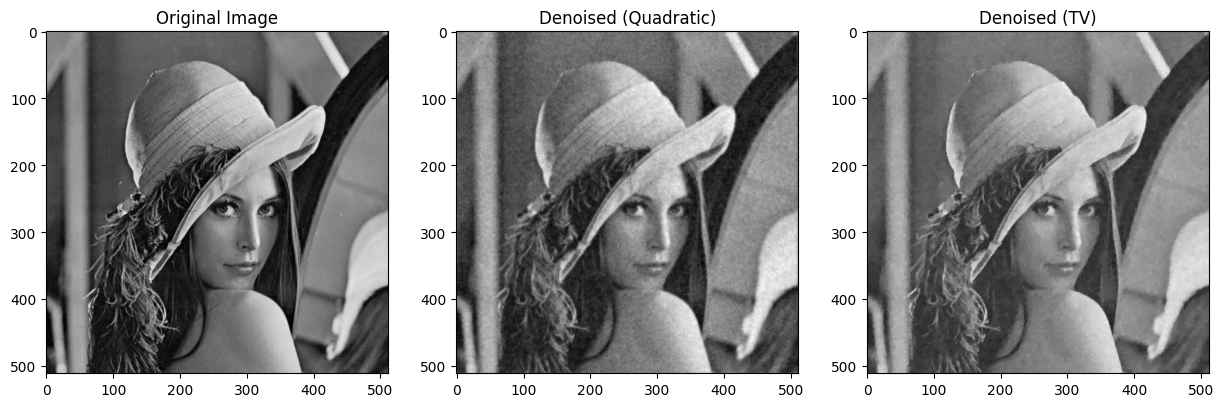

In [32]:
# Denoise using optimal lambda for quadratic method
denoised_quadratic = minimisation_quadratique(imb, corresponding_vk_q)

# Denoise using optimal lambda for TV method
denoised_tv = vartotale_Chambolle(imb, corresponding_vk_vt)

plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(im, cmap='gray'), plt.title('Original Image')
plt.subplot(132), plt.imshow(denoised_quadratic, cmap='gray'), plt.title('Denoised (Quadratic)')
plt.subplot(133), plt.imshow(denoised_tv, cmap='gray'), plt.title('Denoised (TV)')
plt.show()

We have the observation model  $ v = u + b $ and so $ E_1(u) = \| u - v \|^2 + \lambda \| \nabla u \|^2 $

The gradient $ \nabla u $ can be expressed as : 
$ K_x \approx \begin{bmatrix} -1 & 1 & 0 \end{bmatrix} $ and $ K_y \approx \begin{bmatrix} -1 \\ 1 \\ 0 \end{bmatrix} $ and so $ \lambda\| \nabla u \|^2 = \lambda\| K_x \ast u \|^2 + \lambda\| K_y \ast u \|^2 $.

$$ \|\delta \ast u - v\|^2 = \| u - v \|^2 $$

$$ \lambda \| K_x \ast u \|^2 = \lambda \| K_x \ast u - 0 \|^2 $$

$$ \lambda \| K_y \ast u \|^2 = \lambda \| K_y \ast u - 0 \|^2 $$

Then, the problem can be written as: $ E_1(u) = \sum_{i=1}^{3} \| K_i \ast u - V_i \|^2 $

- We use the Fourier Transform and take the derivative of the previous equation and equaling to zero we have this expression:

$$ \sum \mathcal{F}(K_i)^* \cdot [\mathcal{F}(K_i) \cdot \mathcal{F}(u) - \mathcal{F}(V_i)] = 0 $$

$$ \mathcal{F}(u) = \frac{\sum \mathcal{F}(K_i)^* \cdot \mathcal{F}(V_i)}{\sum |\mathcal{F}(K_i)|^2} $$

- Taking the inverse fourier transform we found $u$ Which is the return of the `resoud_quad_fourier`.